In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [10]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()
        self.num_params = num_params
        self.init_params()

    def init_params(self):
        # Swish
        if self.num_params == 4:
            h = torch.tensor([6.0247, 3.0090, 1.5470, 1.0945])
            d = torch.tensor([6.1718, 3.0962, 1.5492, 0.7664])
            T = torch.tensor([5.8070, 2.8584, 1.3577, 0.5687])
        elif self.num_params == 8:
            h = torch.tensor([3.6760, 2.8168, 2.3811, 1.3095, 0.8152, 0.3878, 0.1751, 2.4152])
            d = torch.tensor([3.6922, 2.9805, 2.4332, 1.3228, 0.8048, 0.3861, 0.1863, 0.1023])
            T = torch.tensor([8.2595, 3.5255, 2.5539, 1.7761, 0.9528, 0.5461, 0.3573, 0.2881])
        elif self.num_params == 12:
            h = torch.tensor([1.1299, 6.8735, 4.4682, 2.0329, 1.3388, 0.7357, 0.7149, 0.4261, 0.6461, 0.4154, 0.2179, 0.3444])
            d = torch.tensor([-0.2083,  7.0264,  4.6516,  2.1096,  1.3740,  0.7480,  0.6828,  0.3809, 0.4077,  0.2240,  0.1159,  0.0536])
            T = torch.tensor([-3.5203,  5.9076,  4.0212,  1.8142,  0.9658,  0.3212, -0.0740, -0.4722, -0.7314, -1.2238, -1.3265, -1.4648])
        elif self.num_params == 16:
            h = torch.tensor([0.5602, 0.3329, 1.2282, 1.4916, 1.0170, 1.0777, 0.9202, 1.2722, 2.8685, 1.3212, 0.8411, 0.3989, 0.1870, 0.0936, 0.0616, 1.1349])
            d = torch.tensor([0.3161,  0.2175, -0.2093,  1.6195,  1.0840,  1.1121,  0.9249,  1.2900, 2.8708,  1.3277,  0.8375,  0.3912,  0.1875,  0.0973,  0.0640,  0.0406])
            T = torch.tensor([0.0984, -0.0835, -3.5130,  0.6933,  0.1460,  0.0137,  0.9415,  0.2020, 1.2894, -0.2560, -0.7142, -1.1954, -1.3832, -1.4649, -1.4901, -1.5134])

        # Sigmoid
        #if self.num_params == 4:
        #    h = torch.tensor([0.9813, -1.9998, -0.6859, 0.0726])
        #    d = torch.tensor([0.4719, 0.8930, -0.2312, -0.1692])
        #    T = torch.tensor([-1.2178, -0.0103, 0.9895, 0.9898])
        #elif self.num_params == 8:
        #    h = torch.tensor([6.8620, 3.8446, 3.4882, 1.5610, 1.1893, 1.4751, -2.6189, 0.1495])
        #    d = torch.tensor([0.0891, 0.6711, 0.0253, 0.1613, -0.0060, -0.0086, 0.9554, -0.7933])
        #    T = torch.tensor([9.2329, 0.0567, 2.0161, -1.2216, 0.5962, -0.3178, -2.6367, -1.0322])
        #elif self.num_params == 12:
        #    h = torch.tensor([1.9139, 1.2510, 2.0618, 0.7526, 1.5032, 0.3668, 1.9875, 1.1889, 0.5554, 0.4489, 1.1767, 0.1623])
        #    d = torch.tensor([4.2165e-01, 2.3374e-01, 1.9323e-01, 2.0999e-03, 8.8693e-02, 4.6456e-02, 1.3804e-02, 1.2080e+00, -2.6239e-03, 1.9740e-01, 1.0457e-04, 1.3949e-04])
        #    T = torch.tensor([0.0443, -0.9573, -1.5970, 2.4553, -2.7807, -3.4746, -2.0787, 1.7883, 0.7193, 3.4051, 0.2201, -0.0492])
        #elif self.num_params == 16:
        #    h = torch.tensor([2.5733, 1.3121, 0.8950, 1.0941, 1.5366, 0.5694, 1.4563, 0.9944, 1.0961, -1.9481, 1.2481, 0.3490, 0.4921, 0.7793, 2.7194, 1.0211])
        #    d = torch.tensor([5.1833e-01, 2.2102e-01, 4.7605e-02, 2.9832e-02, 3.1005e-02, 1.4990e-03, 7.6458e-04, 1.1084e-03, 2.5561e-03, 3.2932e-01, -2.5365e-01, 1.2654e+00, 8.7905e-01, 3.2769e-03, 2.2629e-03, 7.1012e-02])
        #    T = torch.tensor([0.1467, -1.1673, -2.9088, -4.0010, -2.0569, 0.0914, 0.6653, 0.5048, 0.2919, -4.0346, -3.0172, 1.8976, 1.8881, 0.3116, 0.0206, -2.8496])

        self.h = nn.Parameter(h + torch.normal(0, 0.000001, size=h.size()))
        self.d = nn.Parameter(d + torch.normal(0, 0.000001, size=d.size()))
        self.T = nn.Parameter(T + torch.normal(0, 0.000001, size=T.size()))
    
    def add_noise(self):
        self.h.data += torch.normal(0, 0.000001, size=self.h.size(), device=self.h.device)
        self.d.data += torch.normal(0, 0.000001, size=self.d.size(), device=self.d.device)
        self.T.data += torch.normal(0, 0.000001, size=self.T.size(), device=self.T.device)

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

K=4

Epoch 1/20000, Loss: 0.03879682719707489
Epoch 1001/20000, Loss: 0.03879697620868683
Epoch 2001/20000, Loss: 0.0387970395386219
Epoch 3001/20000, Loss: 0.038797616958618164
Epoch 4001/20000, Loss: 0.03879617527127266
Epoch 5001/20000, Loss: 0.03879591450095177
Epoch 6001/20000, Loss: 0.03879590332508087
Epoch 7001/20000, Loss: 0.03879699856042862
Epoch 8001/20000, Loss: 0.038796909153461456
Epoch 9001/20000, Loss: 0.038796503096818924
Epoch 10001/20000, Loss: 0.038796912878751755
Epoch 11001/20000, Loss: 0.03879643231630325
Epoch 12001/20000, Loss: 0.03879772126674652
Epoch 13001/20000, Loss: 0.038794539868831635
Epoch 14001/20000, Loss: 0.038797006011009216
Epoch 15001/20000, Loss: 0.038793910294771194
Epoch 16001/20000, Loss: 0.03879689425230026
Epoch 17001/20000, Loss: 0.03879629820585251
Epoch 18001/20000, Loss: 0.038796182721853256
Epoch 19001/20000, Loss: 0.03879700228571892
Loss values: [0.03879682719707489, 0.03879531845450401, 0.03879493474960327, 0.03879616782069206, 0.038795

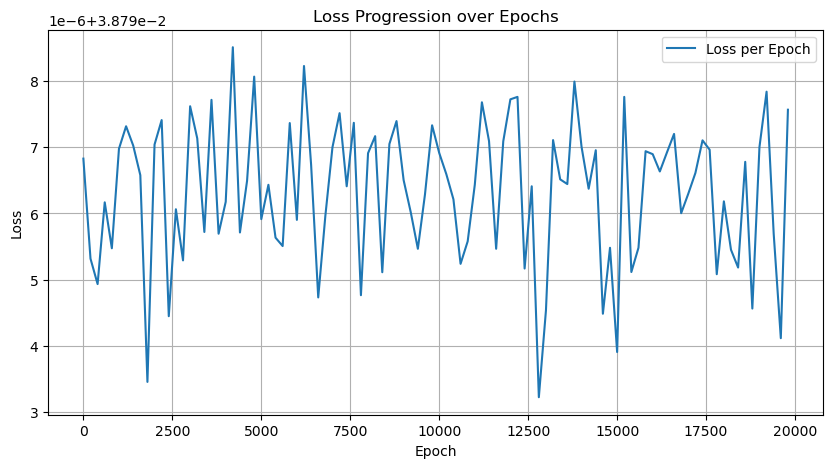

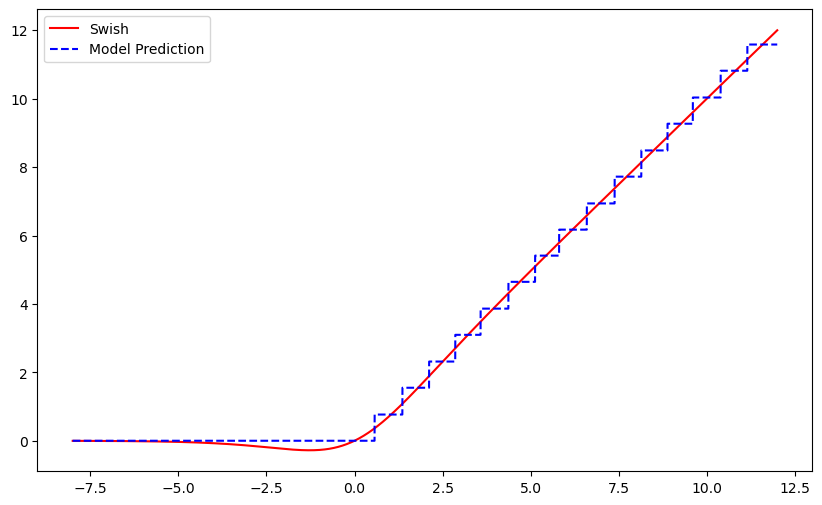

In [11]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
        
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

Epoch 1/20000, Loss: 0.008969314396381378
Epoch 1001/20000, Loss: 0.008964172564446926
Epoch 2001/20000, Loss: 0.008969240821897984
Epoch 3001/20000, Loss: 0.00897439569234848
Epoch 4001/20000, Loss: 0.00897039845585823
Epoch 5001/20000, Loss: 0.008969664573669434
Epoch 6001/20000, Loss: 0.008965319953858852
Epoch 7001/20000, Loss: 0.008970621973276138
Epoch 8001/20000, Loss: 0.008968823589384556
Epoch 9001/20000, Loss: 0.008967825211584568
Epoch 10001/20000, Loss: 0.00896709505468607
Epoch 11001/20000, Loss: 0.008969312533736229
Epoch 12001/20000, Loss: 0.008970017544925213
Epoch 13001/20000, Loss: 0.008968265727162361
Epoch 14001/20000, Loss: 0.008972162380814552
Epoch 15001/20000, Loss: 0.008968888781964779
Epoch 16001/20000, Loss: 0.008969668298959732
Epoch 17001/20000, Loss: 0.00896775908768177
Epoch 18001/20000, Loss: 0.008969747461378574
Epoch 19001/20000, Loss: 0.00896937120705843
Loss values: [0.008969314396381378, 0.00897093303501606, 0.008972234092652798, 0.00896980799734592

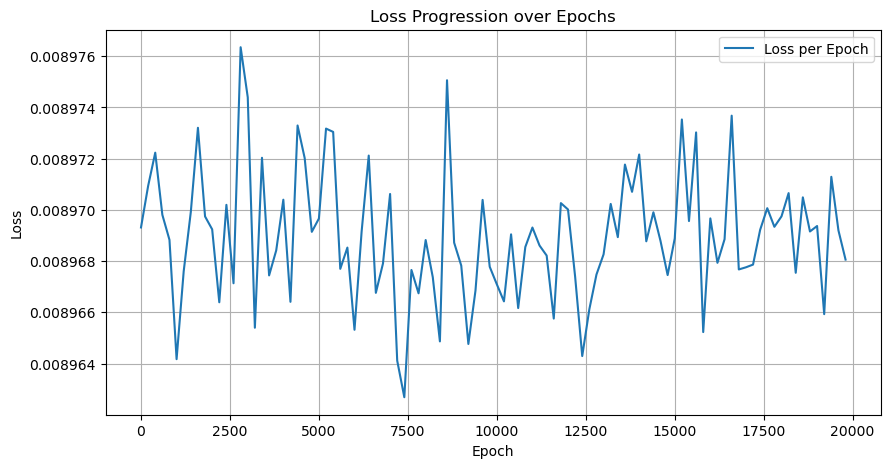

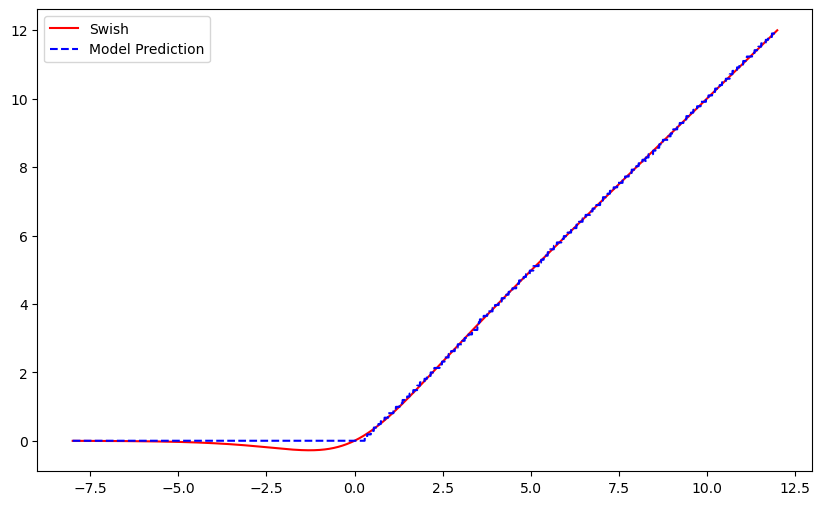

In [12]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
        
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

k=12

Epoch 1/20000, Loss: 0.002046100329607725
Epoch 1001/20000, Loss: 0.001951300073415041
Epoch 2001/20000, Loss: 0.0018014059169217944
Epoch 3001/20000, Loss: 0.001626576529815793
Epoch 4001/20000, Loss: 0.0015891833463683724
Epoch 5001/20000, Loss: 0.0015631916467100382
Epoch 6001/20000, Loss: 0.0015373554779216647
Epoch 7001/20000, Loss: 0.0014957977691665292
Epoch 8001/20000, Loss: 0.0014875262277200818
Epoch 9001/20000, Loss: 0.0014509893953800201
Epoch 10001/20000, Loss: 0.0014856545021757483
Epoch 11001/20000, Loss: 0.0014885526616126299
Epoch 12001/20000, Loss: 0.0014924523420631886
Epoch 13001/20000, Loss: 0.001482696970924735
Epoch 14001/20000, Loss: 0.0014801208162680268
Epoch 15001/20000, Loss: 0.0014802999794483185
Epoch 16001/20000, Loss: 0.0014862462412565947
Epoch 17001/20000, Loss: 0.0014951780904084444
Epoch 18001/20000, Loss: 0.0015101603930816054
Epoch 19001/20000, Loss: 0.0015148395905271173
Loss values: [0.002046100329607725, 0.0020229911897331476, 0.0019844197668135

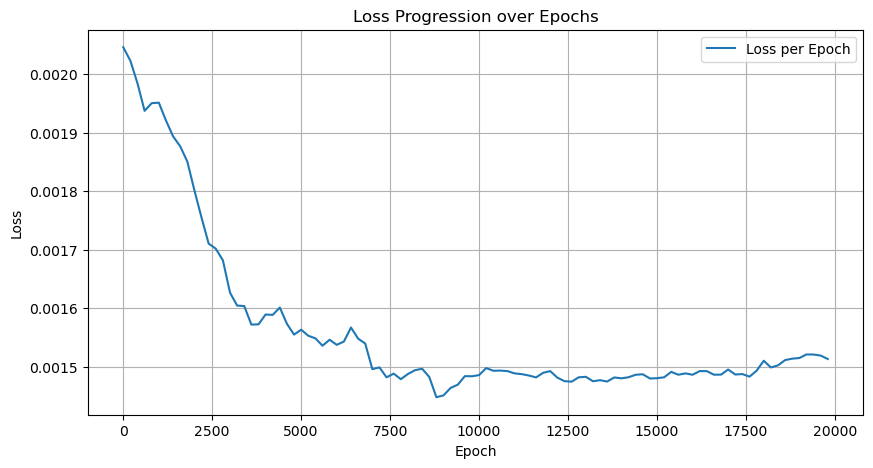

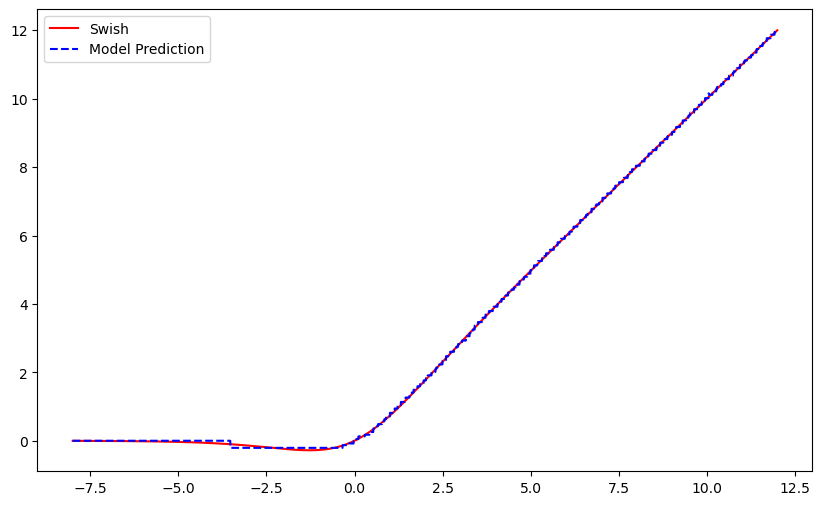

In [13]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
        
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.001042185234837234
Epoch 1001/20000, Loss: 0.001046188990585506
Epoch 2001/20000, Loss: 0.0010502743534743786
Epoch 3001/20000, Loss: 0.0010437698801979423
Epoch 4001/20000, Loss: 0.00104353332426399
Epoch 5001/20000, Loss: 0.0010415237629786134
Epoch 6001/20000, Loss: 0.0010446493979543447
Epoch 7001/20000, Loss: 0.00104626826941967
Epoch 8001/20000, Loss: 0.0010442399652674794
Epoch 9001/20000, Loss: 0.0010395580902695656
Epoch 10001/20000, Loss: 0.0010408884845674038
Epoch 11001/20000, Loss: 0.0010469533735886216
Epoch 12001/20000, Loss: 0.001049707061611116
Epoch 13001/20000, Loss: 0.0010404299246147275
Epoch 14001/20000, Loss: 0.0010435280855745077
Epoch 15001/20000, Loss: 0.001043675234541297
Epoch 16001/20000, Loss: 0.0010500878561288118
Epoch 17001/20000, Loss: 0.0010418895399197936
Epoch 18001/20000, Loss: 0.001045741606503725
Epoch 19001/20000, Loss: 0.001039489172399044
Loss values: [0.001042185234837234, 0.0010333500104025006, 0.001035420224070549, 0.

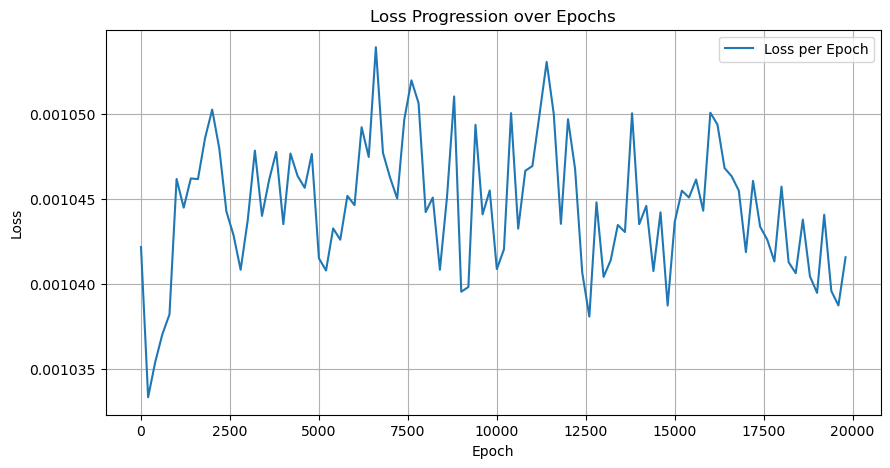

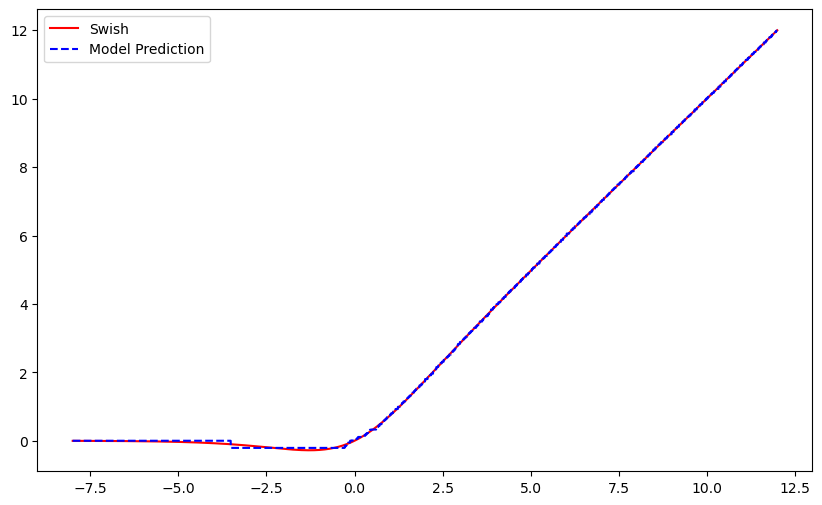

In [14]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
        
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()